# Case Ifood - Analista de Dados SR

## Visão Geral
Neste case técnico, você deverá desenvolver uma solução baseada em dados para direcionar uma estratégia de cupons como alavanca de crescimento. O desafio permitirá que você demonstre suas habilidades em modelagem, estatística e análise de dados, assim como senso crítico e comunicação de resultados.

Leia o case por completo antes de começar a desenvolver sua solução.

**Contexto**

Você foi contratado como Analista de Dados no iFood, uma das maiores empresas de tecnologia da América Latina. Seu primeiro projeto envolve analisar os resultados de um teste A/B realizado recentemente, desenhado para avaliar o impacto de uma estratégia de cupons na retenção de usuários.

Lembre-se de preparar os dados antes da análise utilizando boas práticas do processo de ETL.

# 1.0 Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import findspark
findspark.init()
spark = SparkSession.builder \
    .appName("CaseIfood") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/13 12:49:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2.0 Parameter Settings

# 3.0 Reading Datasets

## 3.1 consumer

Contém dados de cerca de 806k usuários do iFood. Cada usuário possui um
customer_id e os seguintes atributos complementares:
- customer_id (string): Identificador do usuário
- language (string): Idioma do usuário
- created_at (timestamp): Data e hora em que o usuário foi criado
- active (bool): Flag indicando se o usuário está ativo ou não
- customer_name (string): Primeiro nome do usuário
- customer_phone_area (string): Código de área do telefone do usuário
- customer_phone_number (string): Número do telefone do usuário

In [3]:
consumer = spark.read.csv('Bases/consumer.csv', header=True, inferSchema=True)
consumer.show(5)

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 11:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14 19:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07 01:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 20:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-05 21:16:...|  true|       WENDER|                 76|            543232158|
+--------------------+--------+--------------------+------+-------------

## 3.2 restaurant

Contém dados de cerca de 7k restaurantes do iFood. Cada restaurante possui
um id e os seguintes atributos complementares:
- id (string): Identificador do restaurante
- created_at (timestamp): Data e hora em que o restaurante foi criado
- enabled (bool): Flag indicando se o restaurante está ativo no iFood ou
não
- price_range (int): Classificação de preço do restaurante
- average_ticket (float): Ticket médio dos pedidos no restaurante
- delivery_time (float): Tempo padrão de entrega para pedidos no restaurante
- minimum_order_value (float): Valor mínimo para pedidos no restaurante
- merchant_zip_code (string): CEP do restaurante
- merchant_city (string): Cidade do restaurante
- merchant_state (string): Estado do restaurante
- merchant_country (string): País do restaurante

In [4]:
restaurant = spark.read.csv('Bases/restaurant.csv', header=True, inferSchema=True)
restaurant.show(5)

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23 10:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20 11:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23 10:46:...|  

## 3.3 ab_test_ref

Contém uma marcação indicando se um usuário participou do teste A/B em
questão. Assim como a base de usuários, cada usuário possui um customer_id.
Os campos são:
- customer_id (string): Identificador do usuário
- is_target (string): Grupo ao qual o usuário pertence ('target' ou
'control').

In [5]:
ab_test_ref = spark.read.csv('Bases/ab_test_ref.csv', header=True, inferSchema=True)
ab_test_ref.show(5)

25/03/13 12:49:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
|b821aa8372b8e5b82...|  control|
|d425d6ee4c9d4e211...|  control|
|6a7089eea0a5dc294...|   target|
|dad6b7e222bab31c0...|  control|
+--------------------+---------+
only showing top 5 rows



## 3.4 order

Contém dados de cerca de 3.6 milhões de pedidos realizados entre dez/18 e
jan/19. Cada pedido possui um order_id e os seguintes atributos complementares:
- cpf (string): Cadastro de Pessoa Física do usuário que realizou o pedido
- customer_id (string): Identificador do usuário
- customer_name (string): Primeiro nome do usuário
- delivery_address_city (string): Cidade de entrega do pedido
- delivery_address_country (string): País da entrega
- delivery_address_district (string): Bairro da entrega
- delivery_address_external_id (string): Identificador do endereço
de entrega
- delivery_address_latitude (float): Latitude do endereço de entrega
- delivery_address_longitude (float): Longitude do endereço de
entrega
- delivery_address_state (string): Estado da entrega
- delivery_address_zip_code (string): CEP da entrega
- items (array[json]): Itens que compõem o pedido, bem como informações complementares como preço unitário, quantidade, etc. 
- merchant_id (string): Identificador do restaurante
- merchant_latitude (float): Latitude do restaurante
- merchant_longitude (float): Longitude do restaurante
- merchant_timezone (string): Fuso horário em que o restaurante está
localizado
- order_created_at (timestamp): Data e hora em que o pedido foi criado
- order_id (string): Identificador do pedido
- order_scheduled (bool): Flag indicando se o pedido foi agendado ou
não (pedidos agendados são aqueles que o usuário escolheu uma data
e hora para a entrega)
- order_total_amount (float): Valor total do pedido em Reais
- origin_platform (string): Sistema operacional do dispositivo do
usuário
- order_scheduled_date (timestamp): Data e horário para entrega do
pedido agendado

In [6]:
order = spark.read.json('Bases/order.json').repartition(32)
order.show(5)

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

In [7]:
order.agg(
    min(col('order_created_at')),
    max(col('order_created_at'))
).show()

+---------------------+---------------------+
|min(order_created_at)|max(order_created_at)|
+---------------------+---------------------+
| 2018-12-03T00:00:...| 2019-01-31T23:59:...|
+---------------------+---------------------+



# 4. Desafio

## 4.1 Parte 1

No iFood, várias áreas utilizam testes A/B para avaliar o impacto de ações em diferentes métricas. Esses testes permitem validar hipóteses de crescimento e a viabilidade de novas funcionalidades em um grupo restrito de usuários. Nos dados fornecidos nesse case você encontrará
uma marcação de usuários, separando-os entre grupo teste e controle de uma campanha de cupons, que disponibilizou para os usuários do grupo teste um cupom especial.
- a) Defina os indicadores relevantes para mensurar o sucesso da campanha e analise se ela teve impacto significativo dentro do período avaliado.
- b) Faça uma análise de viabilidade financeira dessa iniciativa como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).
- c) Recomende oportunidades de melhoria nessa ação e desenhe uma nova proposta de teste A/B para validar essas hipóteses.

### 4.1.1 Exploração das bases

#### Share Controle x Target

In [8]:
consumer_target = consumer.join(
    ab_test_ref,
    'customer_id',
    'left'
)
consumer_target.show(5)

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+---------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|is_target|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+---------+
|2d5bd6934eed5dd0f...|   pt-br|2018-01-10 21:25:...|  true|    ALEXANDRE|                 51|            672425898|   target|
|5ec395c12db7a2b8e...|   pt-br|2018-01-03 20:01:...|  true|       NAYARA|                 25|            578145642|   target|
|770506a7f20643b9c...|   pt-br|2018-04-06 01:12:...|  true|        LIVIA|                 61|             34698538|  control|
|856421dfffe6d8619...|   pt-br|2018-03-16 20:00:...|  true|       FELIPE|                 78|            133158219|   target|
|d08fcfb519e6f0db7...|   pt-br|2018-04-06 01:22:...|  true|   ALESSANDRA|                 12|            733739311|   

In [9]:
qtde_customer_total = consumer_target.count()

consumer_target.groupBy('is_target').agg(
    countDistinct(col('customer_id')).alias('Qtde_Customer_id'),
    round(countDistinct(col('customer_id'))/qtde_customer_total, 2).alias('Share')
).show()

+---------+----------------+-----+
|is_target|Qtde_Customer_id|Share|
+---------+----------------+-----+
|  control|          360413| 0.45|
|   target|          445743| 0.55|
+---------+----------------+-----+



#### Agrupamento orders

In [10]:
order.show(5)

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

In [11]:
order = order.withColumn('order_created_at', col('order_created_at').cast('timestamp'))
window_spec = Window.partitionBy('customer_id').orderBy('order_created_at')
order = order.withColumn('time_between_orders', col('order_created_at') - lag('order_created_at').over(window_spec))
#order.show(10)

In [12]:
#order.filter(col('customer_id') == '0009fce56b3f5a32ae7449b5d7dccff58945a0b21c44bca71fa1b523cdfdeafc').show()

In [13]:
order_total = order.groupBy('customer_id').agg(
    count(col('order_id')).alias('qtde_orders'),
    countDistinct(col('merchant_id')).alias('qtde_merchant_id'),
    sum(col('order_total_amount')).alias('order_total_amount'),
    avg(col('time_between_orders')).alias('avg_time_between_orders'),
)

In [14]:
order_total.agg(
sum(col('qtde_orders'))
).show()

+----------------+
|sum(qtde_orders)|
+----------------+
|         3670826|
+----------------+



In [15]:
order_total.agg(
count(col('customer_id'))
).show()

+------------------+
|count(customer_id)|
+------------------+
|            806466|
+------------------+



In [16]:
3670826 / 806466

4.551743036904222

In [17]:
consumer_total_amount = consumer_target.join(
    order_total,
    'customer_id',
    'left'
).toPandas()

25/03/13 12:54:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:54:36 WARN RowBasedKeyValueBatch: Calling spill() on

In [18]:
consumer_total_amount['avg_time_between_orders'] = (consumer_total_amount['avg_time_between_orders'].dt.total_seconds()/60/60/24).round(4)
consumer_total_amount['avg_order_price'] = (consumer_total_amount['order_total_amount'] / consumer_total_amount['qtde_orders']).round(4)
consumer_total_amount

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806151,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,pt-br,2018-01-21 14:54:13.123,True,SUZY,44,913950529,target,2,1,94.00,30.0000,47.0000
806152,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,pt-br,2018-01-07 21:55:07.377,True,Gustavo,15,9534999,target,9,4,716.20,6.6232,79.5778
806153,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,pt-br,2018-01-03 13:34:50.747,True,MARA,45,831631680,target,4,2,192.60,11.4560,48.1500
806154,fffef917711775d1ba63ec1d8054f9705177edef950699...,pt-br,2018-04-05 10:16:05.922,True,JOAO,34,713368500,control,2,1,47.60,30.0000,23.8000


In [19]:
consumer_total_amount[consumer_total_amount['qtde_orders'] == 1]

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.60
7,000ac4b0d62aaf4891e102849ff0cdbf41f72d5e3860cd...,pt-br,2018-04-02 21:17:53.431,True,STEFANI,56,584363395,control,1,1,86.03,NaN,86.03
10,0015f1e5b35a3d7b66d9fd64271e1633200d44bbcdb63b...,pt-br,2018-04-05 21:09:00.704,True,THAYNÁ,80,772230201,target,1,1,49.90,NaN,49.90
15,001da63dc14d67ab0853ed429d97f5e4f00c6825fd1b5d...,pt-br,2018-04-06 00:52:59.215,True,DAVID,26,557604844,control,1,1,82.80,NaN,82.80
16,001ee69ed95d6330f6419bcd72b944802ed15bfcbd147e...,pt-br,2018-01-07 15:28:22.138,True,JADER,51,593319222,control,1,1,27.90,NaN,27.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806136,ffeabf6b39f96182ee3cd6947f9a210947a5d2bcf1592e...,pt-br,2018-01-11 20:53:06.603,True,MARCELO,0,393381731,control,1,1,49.00,NaN,49.00
806139,ffee546132280351ccd73231478ee4fc783228b381b110...,pt-br,2018-04-05 19:19:07.053,True,KAIE,83,76789604,target,1,1,53.50,NaN,53.50
806140,ffef768a3b772960b02a81a1ebe096800374f42f7abb69...,pt-br,2018-01-12 21:08:10.163,True,MARIA,30,771046751,target,1,1,64.90,NaN,64.90
806143,fff0eacd8d2ee54d6bc96b8c54608b0c721369f99bfcab...,pt-br,2018-01-14 08:30:57.499,True,MARIANA,59,509844190,control,1,1,78.50,NaN,78.50


#### Explorando total_amount

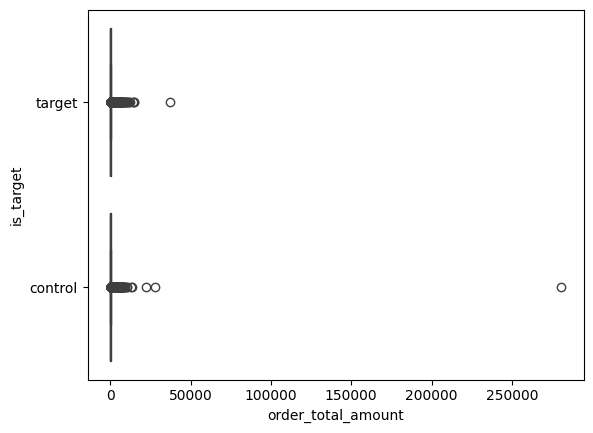

In [20]:
# Boxplot
sns.boxplot(x='order_total_amount',
            y='is_target', 
            data=consumer_total_amount)
plt.show()

In [21]:
# Calcular os quartis e Limites
Q1 = consumer_total_amount['order_total_amount'].quantile(0.25)
Q2 = consumer_total_amount['order_total_amount'].quantile(0.50)
Q3 = consumer_total_amount['order_total_amount'].quantile(0.75)
IQR = Q3 - Q1
Min1 = Q1 - (1.5 * IQR)
Max1 = Q3 + (1.5 * IQR)

# Exibir os quartis e Limites
print('1º Quartil (Q1):', Q1)
print('2º Quartil (Q2 - Mediana):', Q2)
print('3º Quartil (Q3):', Q3)
print('Minimum:', Min1)
print('maximum:', Max1)


1º Quartil (Q1): 56.0
2º Quartil (Q2 - Mediana): 111.6
3º Quartil (Q3): 243.2
Minimum: -224.79999999999995
maximum: 524.0


In [22]:
consumer_total_amount_sem_outlier = consumer_total_amount[(consumer_total_amount['order_total_amount'] > Min1) & (consumer_total_amount['order_total_amount'] < Max1)]
print(f'Share de outliers: {1 - (consumer_total_amount_sem_outlier.shape[0] / consumer_total_amount.shape[0]):.4f}')

Share de outliers: 0.0920


In [23]:
consumer_total_amount_sem_outlier[['qtde_orders', 'qtde_merchant_id']].describe()

,qtde_orders,qtde_merchant_id
count,731996.000000,731996.000000
mean,3.313351,1.741626
std,2.859604,1.187096
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,4.000000,2.000000
max,46.000000,15.000000


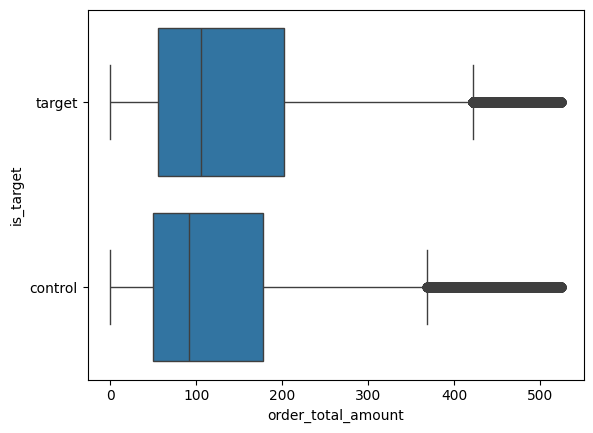

In [24]:
# Boxplot sem outliers
sns.boxplot(x='order_total_amount', 
            y='is_target', 
            data=consumer_total_amount_sem_outlier)
plt.show()

In [25]:
avg_total_order_amount_target  = consumer_total_amount_sem_outlier[consumer_total_amount_sem_outlier['is_target'] == 'target']['order_total_amount'].mean()
avg_total_order_amount_control = consumer_total_amount_sem_outlier[consumer_total_amount_sem_outlier['is_target'] == 'control']['order_total_amount'].mean()

variacao1 = avg_total_order_amount_target - avg_total_order_amount_control
variacao_poercentual1 = variacao1 / avg_total_order_amount_control * 100

print(f"Média Total Order Amount Target: R${avg_total_order_amount_target:.2f}")
print(f"Média Total Order Amount Control: R${avg_total_order_amount_control:.2f}")
print(f"Variação entre as médias: R${variacao1:.2f}")
print(f"Variação percentual entre as médias: {variacao_poercentual1:.2f} %")


Média Total Order Amount Target: R$145.34
Média Total Order Amount Control: R$131.60
Variação entre as médias: R$13.74
Variação percentual entre as médias: 10.44 %


In [26]:
target1 = consumer_total_amount_sem_outlier[consumer_total_amount_sem_outlier['is_target'] == 'target']['order_total_amount']
control1 = consumer_total_amount_sem_outlier[consumer_total_amount_sem_outlier['is_target'] == 'control']['order_total_amount']

# Calculando o teste t
t_stat1, p_value1 = stats.ttest_ind(target1, control1)

# Exibindo os resultados
print(f"Estatística t: {t_stat1}")
print(f"p-valor: {p_value1}")
if p_value1 < 0.05:
    print("Resultado estatisticamente significativo (rejeita H0).")
else:
    print("Resultado NÃO é estatisticamente significativo (não rejeita H0).")

Estatística t: 50.591931868091976
p-valor: 0.0
Resultado estatisticamente significativo (rejeita H0).


#### Criando Função

In [27]:
consumer_total_amount

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806151,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,pt-br,2018-01-21 14:54:13.123,True,SUZY,44,913950529,target,2,1,94.00,30.0000,47.0000
806152,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,pt-br,2018-01-07 21:55:07.377,True,Gustavo,15,9534999,target,9,4,716.20,6.6232,79.5778
806153,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,pt-br,2018-01-03 13:34:50.747,True,MARA,45,831631680,target,4,2,192.60,11.4560,48.1500
806154,fffef917711775d1ba63ec1d8054f9705177edef950699...,pt-br,2018-04-05 10:16:05.922,True,JOAO,34,713368500,control,2,1,47.60,30.0000,23.8000


In [28]:
variavel = 'order_total_amount'
df = consumer_total_amount
name = 'Avg Total Order Amount'
unit = 'reais'

def kpi_sumary(df, variavel, name, unit, def_bin=30):
    # Exclude outliers
    # Find out quantile, minimun and max
    Q1 = df[variavel].quantile(0.25)
    Q2 = df[variavel].quantile(0.50)
    Q3 = df[variavel].quantile(0.75)
    IQR = Q3 - Q1
    Min = Q1 - (1.5 * IQR)
    Max = Q3 + (1.5 * IQR)

    # Filter outliers
    df_witout_outliers = df[(df[variavel] > Min) & (df[variavel] < Max)]
    share_outliers = (1 - df_witout_outliers.shape[0] / df.shape[0]) * 100

    # Resume
    target  = df_witout_outliers[df_witout_outliers['is_target'] == 'target'][variavel]
    control = df_witout_outliers[df_witout_outliers['is_target'] == 'control'][variavel]
    target_mean  = target.mean()
    control_mean = control.mean()

    variation = target_mean - control_mean
    percent_variantion = variation / control_mean * 100


    print(f"------Summary Data------")
    print(f"Dataset size: {df.shape[0]}")
    print(f"Target Share: {df[df['is_target'] == 'target'].shape[0] / df.shape[0] * 100:.2f}%")
    print(f"Share of Outliers: {share_outliers:.2f}%")
    print(f"Dataset size sem outliers: {df_witout_outliers.shape[0]}")
    print(f"Quantidade de Pedidos: {df_witout_outliers['qtde_orders'].sum()}")
    print(f"Quantidade de Consumidores: {df_witout_outliers['customer_id'].count()}")
    print(f"Total Amount: {df_witout_outliers['order_total_amount'].sum():.2f}")
    print(f"{name} (Target Group): {target_mean:.2f} {unit}")
    print(f"{name} (Control Group): {control_mean:.2f} {unit}")
    print(f"Difference in Means: {variation:.2f} {unit}")
    print(f"Percentage Difference in Means: {percent_variantion:.2f}%")


    # Performing a t-test
    t_stat, p_value = stats.ttest_ind(target, control)
    print(f"")
    print(f"-----Performing a t-test-----")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Statistically significant result (reject H₀).")
    else:
        print("Not statistically significant (fail to reject H₀).")

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    custom_palette = {'target': 'lightcoral', 'control': 'lightgray'}


    # Boxplot without outliers
    sns.boxplot(x=variavel, y='is_target', data=df_witout_outliers, hue='is_target', ax=axes[0], palette=custom_palette)
    axes[0].set_title(f"Boxplot of {name} without Outliers")

    # Histogram
    sns.histplot(data=df_witout_outliers, x=variavel, hue='is_target', bins=def_bin, alpha=0.5, ax=axes[1], palette=custom_palette)
    axes[1].set_title(f"Histogram of {name} by Target Group")
    axes[1].set_xlabel(variavel)
    axes[1].set_ylabel("Frequency")

    plt.tight_layout() 
    plt.show()

### 4.1.2 Parte 1 - a)
Defina os indicadores relevantes para mensurar o sucesso da campanha e analise se ela teve impacto significativo dentro do período avaliado.
Os indicadores que eu eu considero relavante para o sucesso do teste são:

**Principal KPI**
* Média de pedidos realizados no período: por se tratar do indicador que mede a frequência de comprar no app. Como o teste oferece cupons para o consumidor, espera-se que esse incentivo aumente a qunatidade de pedidos.

**KPI's complementares**
* Média de valor total gasto pelo consumidor: Com um número maior de pedidos é esperado que o consumidor gaste mais no valor total acumulado.
* Média de valor médio por pedido: uma vez que o consumidor possui cupons, podemos esperar que isso o incentive a consumir mais itens ou experimentar restaurantes com valores mais altos.

#### Principal KPI

In [29]:
2126786 / 715830

2.9710769316737213

------Summary Data------
Dataset size: 806156
Target Share: 55.29%
Share of Outliers: 11.20%
Dataset size sem outliers: 715830
Quantidade de Pedidos: 2126786
Quantidade de Consumidores: 715830
Total Amount: 102096384.32
Avg Orders (Target Group): 3.11 orders
Avg Orders (Control Group): 2.81 orders
Difference in Means: 0.30 orders
Percentage Difference in Means: 10.81%

-----Performing a t-test-----
t-statistic: 61.68376374627346
p-value: 0.0
Statistically significant result (reject H₀).


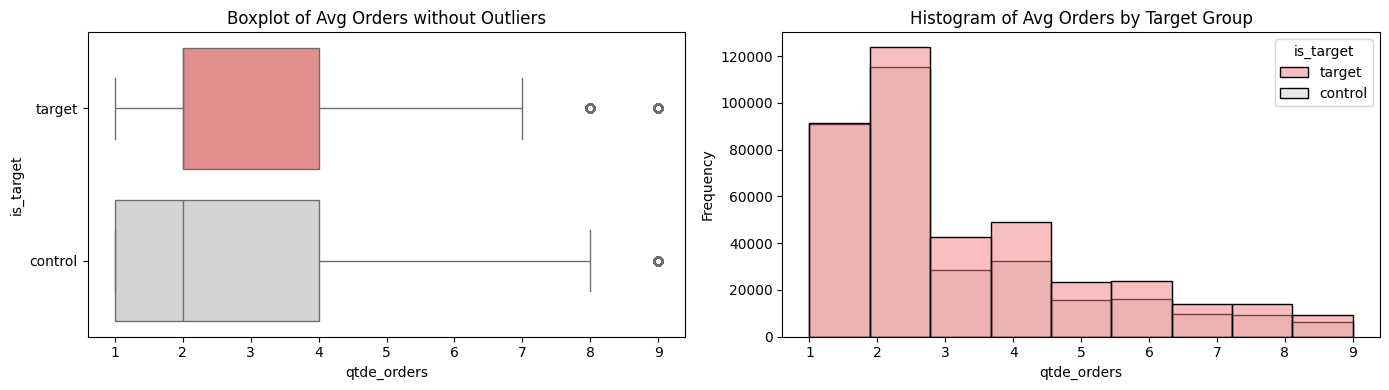

In [30]:
kpi_sumary(consumer_total_amount, 'qtde_orders', 'Avg Orders', 'orders', 9)

Os resultados indicam que a oferta de cupons gerou um aumento significativo na média de pedidos dos usuários do grupo teste. Com uma variação positiva de 11,06% e um resultado estatisticamente robusto, podemos concluir que a estratégia foi eficaz em impulsionar a retenção de usuários dentro do período analisado.

#### KPI's complementares

------Summary Data------
Dataset size: 806156
Target Share: 55.29%
Share of Outliers: 9.20%
Dataset size sem outliers: 731996
Quantidade de Pedidos: 2425360
Quantidade de Consumidores: 731996
Total Amount: 101844787.86
Avg Total Order Amount (Target Group): 145.34 reais
Avg Total Order Amount (Control Group): 131.60 reais
Difference in Means: 13.74 reais
Percentage Difference in Means: 10.44%

-----Performing a t-test-----
t-statistic: 50.591931868091976
p-value: 0.0
Statistically significant result (reject H₀).


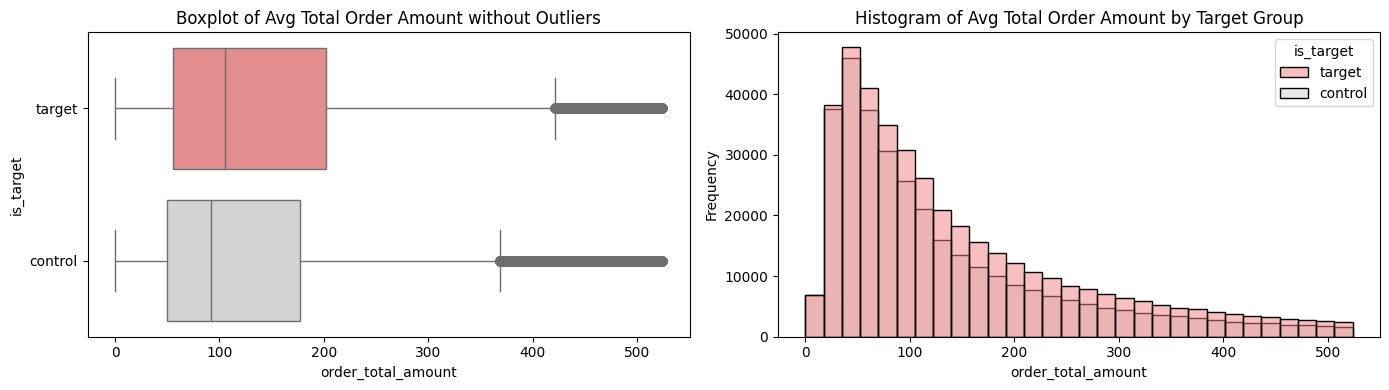

In [31]:
kpi_sumary(consumer_total_amount, 'order_total_amount', 'Avg Total Order Amount', 'reais')

------Summary Data------
Dataset size: 806156
Target Share: 55.29%
Share of Outliers: 5.43%
Dataset size sem outliers: 762361
Quantidade de Pedidos: 3490180
Quantidade de Consumidores: 762361
Total Amount: 151784398.54
Avg Order Price (Target Group): 42.61 reais
Avg Order Price (Control Group): 42.37 reais
Difference in Means: 0.24 reais
Percentage Difference in Means: 0.57%

-----Performing a t-test-----
t-statistic: 5.6800166931401925
p-value: 1.3473039018631461e-08
Statistically significant result (reject H₀).


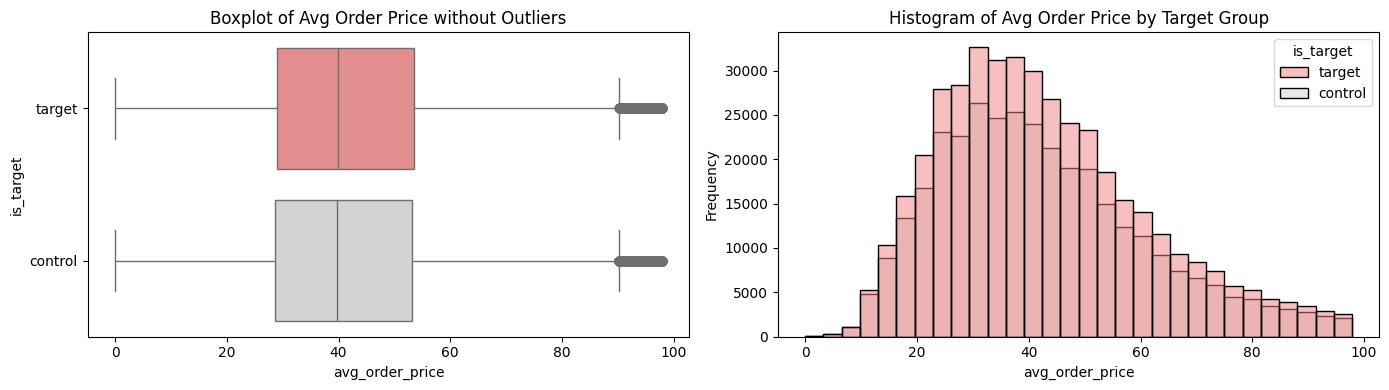

In [32]:
kpi_sumary(consumer_total_amount, 'avg_order_price', 'Avg Order Price', 'reais')

------Summary Data------
Dataset size: 806156
Target Share: 55.29%
Share of Outliers: 22.64%
Dataset size sem outliers: 623635
Quantidade de Pedidos: 3478529
Quantidade de Consumidores: 623635
Total Amount: 166246591.32
Avg time Between Orders (Target Group): 14.93 days
Avg time Between Orders (Control Group): 16.73 days
Difference in Means: -1.80 days
Percentage Difference in Means: -10.77%

-----Performing a t-test-----
t-statistic: -66.30944485759848
p-value: 0.0
Statistically significant result (reject H₀).


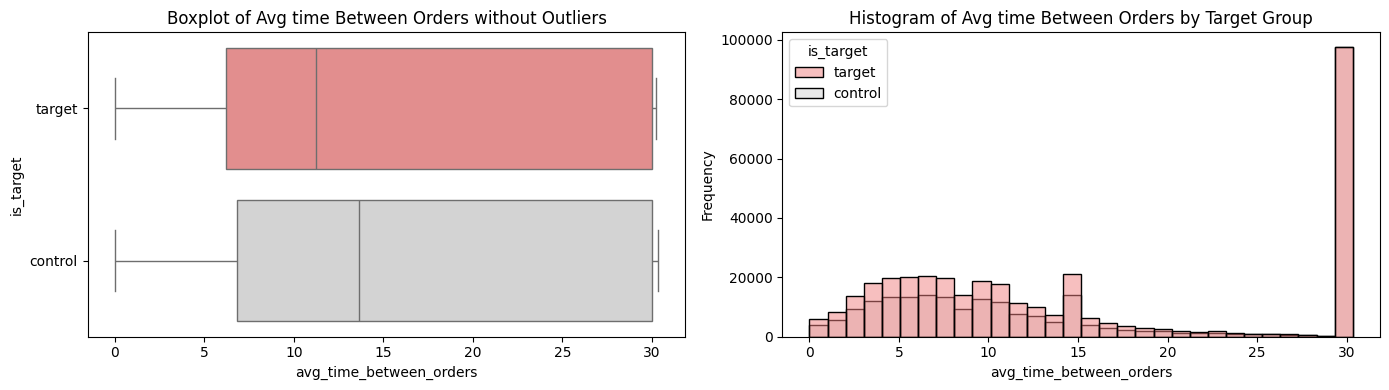

In [33]:
kpi_sumary(consumer_total_amount, 'avg_time_between_orders', 'Avg time Between Orders', 'days')

#### Conclusão

**1. Quantidade de Pedidos (KPI Principal)**
- Impacto positivo: O grupo que recebeu cupons realizou, em média, 10,81% mais pedidos em relação ao grupo controle.
- Média de pedidos – Grupo Teste: 3,11
- Média de pedidos – Grupo Controle: 2,81
- Diferença absoluta: +0,30 pedidos
- Teste t: Estatisticamente significativo (p-valor = 0.0)

**Conclusão:** A campanha aumentou significativamente a frequência de pedidos, indicando um impacto positivo na retenção de usuários.

--

**2. Valor Total Gasto**
- Aumento no gasto total: Usuários do grupo teste gastaram 10,44% a mais no período.
- Média – Grupo Teste: R$ 145,34
- Média – Grupo Controle: R$ 131,60
- Diferença absoluta: +R$ 13,74
- Teste t: Estatisticamente significativo (p-valor = 0.0)

**Conclusão:** O aumento na quantidade de pedidos resultou em um crescimento proporcional no valor total gasto.

--

**3. Ticket Médio (Valor Médio por Pedido)**
- Impacto mínimo: O ticket médio variou apenas +0,57%, sugerindo que os cupons não influenciaram significativamente o valor por pedido.
- Média – Grupo Teste: R$ 42,61
- Média – Grupo Controle: R$ 42,37
- Diferença absoluta: +R$ 0,24
- Teste t: Estatisticamente significativo (p-valor ≈ 1.35e-08)

**Conclusão:** O crescimento no valor total gasto se deu pelo aumento na recorrência dos pedidos, e não pelo aumento no ticket médio.

--

**4. Tempo Médio Entre Pedidos**
- Redução no tempo entre pedidos: O grupo teste realizou novos pedidos 1,80 dias mais cedo, representando uma diminuição de -10,77% no tempo médio entre pedidos.
- Média – Grupo Teste: 14,93 dias
- Média – Grupo Controle: 16,73 dias
- Diferença absoluta: -1,80 dias
- Teste t: Estatisticamente significativo (p-valor = 0.0)

**Conclusão:** A campanha incentivou os usuários a pedirem com maior frequência, reduzindo o intervalo entre compras.

--

**Conclusão Geral**
- A campanha de cupons teve um impacto positivo e estatisticamente significativo nos principais indicadores de retenção:
- Aumento de 10,81% na quantidade de pedidos, impulsionando a recorrência.
- Crescimento de 10,44% no valor total gasto, reforçando o impacto positivo na receita.
- Redução de 10,77% no tempo médio entre pedidos, sugerindo maior engajamento.
- Variação mínima no ticket médio (+0,57%), indicando que o efeito principal foi no volume de pedidos, e não no valor individual gasto.

### 4.1.3 Parte 1 - b)
Faça uma análise de viabilidade financeira dessa iniciativa como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).

**Premissas adotadas:**
- Para calcular o impacto irei considerar para o grupo impactado os KPI's do controle controle e entender a diferença como o valor incremental da campanha;
- A taxa do iFood foi calculada como a média entre os planos Básico (12%) e Entrega (23%), uma vez que não temos informações sobre o plano específico do parceiro. A comissão sobre pedidos foi então calculada da seguinte forma: (12% + 23%) / 2 = 17,5%.
- Considerei também que todos os pedidos foram pagos via iFood, o que implica uma taxa adicional de 3,2%.
- Embora o fee de pagamento tenha sido calculado, esse valor provavelmente é gasto para manter o funcionamento do meio de pagamento e, portanto, não será considerado para esta análise financeira.
- Assumiu-se que não há custos operacionais associados ao aumento do número de pedidos, ou seja, todo o incremento será considerado como lucro.

Fontes:
- Taxas: https://parceiros.ifood.com.br/restaurante

In [34]:
consumer_total_amount.head()

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567


In [35]:
viabilidade_financeira = consumer_total_amount[['customer_id', 'is_target', 'qtde_orders', 'order_total_amount']]

In [36]:
# Calcula médias reais
avg_qtde_orders_control  = consumer_total_amount[consumer_total_amount['is_target'] == 'control']['qtde_orders'].mean()
avg_total_order_amount_control  = consumer_total_amount[consumer_total_amount['is_target'] == 'control']['order_total_amount'].mean()
avg_qtde_orders_target  = consumer_total_amount[consumer_total_amount['is_target'] == 'target']['qtde_orders'].mean()
avg_total_order_amount_target  = consumer_total_amount[consumer_total_amount['is_target'] == 'target']['order_total_amount'].mean()

print(avg_qtde_orders_control)
print(avg_total_order_amount_control)
print(avg_qtde_orders_target)
print(avg_total_order_amount_target)

4.231417845638198
202.6739586807357
4.791981029427271
228.77134999315751


In [37]:
# Cria dataframe para análise de Viabildiade Financeira
viabilidade_financeira = consumer_total_amount.groupby('is_target').agg({'customer_id': 'nunique',
                                                                         'qtde_orders': 'sum',
                                                                         'order_total_amount': 'sum'})

# Calcula Dados de Comissão e Fee de pagamento reais
viabilidade_financeira['sales_commission'] = (viabilidade_financeira['order_total_amount'] * 0.175).round(2)
viabilidade_financeira['payment_fee']      = (viabilidade_financeira['order_total_amount'] * 0.032).round(2)

# Estima dados com médias de controle
viabilidade_financeira['qtde_orders_est']        = viabilidade_financeira['customer_id'] * avg_qtde_orders_control
viabilidade_financeira['order_total_amount_est'] = viabilidade_financeira['customer_id'] * avg_total_order_amount_control
viabilidade_financeira['sales_commission_est']   = (viabilidade_financeira['order_total_amount_est'] * 0.175).round(2)
viabilidade_financeira['payment_fee_est']        = (viabilidade_financeira['order_total_amount_est'] * 0.032).round(2)

viabilidade_financeira['diff_total_amount']  = (viabilidade_financeira['sales_commission'] - viabilidade_financeira['sales_commission_est']).round(2)
viabilidade_financeira['diff_payment_fee']   = (viabilidade_financeira['payment_fee'] - viabilidade_financeira['payment_fee_est']).round(2)
viabilidade_financeira


,customer_id,qtde_orders,order_total_amount,sales_commission,payment_fee,qtde_orders_est,order_total_amount_est,sales_commission_est,payment_fee_est,diff_total_amount,diff_payment_fee
is_target,,,,,,,,,,,
control,360413,1525058,7.304633e+07,12783107.66,2337482.54,1.525058e+06,7.304633e+07,12783107.66,2337482.54,0.00,0.00
target,445743,2135992,1.019732e+08,17845314.88,3263143.29,1.886125e+06,9.034050e+07,15809587.21,2890895.95,2035727.67,372247.34


In [38]:
avg_qtde_orders_control

4.231417845638198

In [39]:
(viabilidade_financeira[viabilidade_financeira.index == 'target']['diff_total_amount'].iloc[0] / viabilidade_financeira[viabilidade_financeira.index == 'target']['customer_id'].iloc[0]).round(2)

4.57

In [40]:
diff_total_amount    = viabilidade_financeira[viabilidade_financeira.index == 'target']['diff_total_amount'].iloc[0]
diff_payment_fee     = viabilidade_financeira[viabilidade_financeira.index == 'target']['diff_payment_fee'].iloc[0]
qtde_customer_target = viabilidade_financeira[viabilidade_financeira.index == 'target']['customer_id'].iloc[0]

print(f'------Summary------')
print(f'Valor incremental em comissão: R${diff_total_amount:,.2f}')
print(f'Valor incremental em fee de pagamento: R${diff_payment_fee:,.2f}')
print(f'Valor incremental por usuário: R${(diff_total_amount / qtde_customer_target).round(2):,.2f}')

------Summary------
Valor incremental em comissão: R$2,035,727.67
Valor incremental em fee de pagamento: R$372,247.34
Valor incremental por usuário: R$4.57


**Conclusão**

A ação gerou um incremento de R$ 2 milhões em comissões. No entanto, esse valor representa o valor bruto resultante da ação. Ao dividir esse valor pela quantidade de clientes impactados, chegamos a um valor incremental de R$ 4,57 por cliente. Para que a ação seja financeiramente viável, espera-se que o valor gasto pelo iFood em cupons seja inferior ao valor incremental gerado. Considerando os valores típicos de cupons do iFood (R$ 10, R$ 15, R$ 20), estima-se que a ação não tenha alcançado a viabilidade financeira caso o iFood tenha arcado com o custo dos cupons, pois o desembolso provavelmente foi superior ao ganho incremental gerado.

No entanto, caso os restaurantes parceiros tenham arcado com o custo dos cupons, a análise financeira muda significativamente. Nesse cenário, o custo dos cupons não afetaria o lucro do iFood, e o incremento de R$ 2 milhões em comissões representaria lucro bruto para o iFood. Isso tornaria a ação financeiramente viável, com um impacto positivo no resultado financeiro.

### 4.1.4 Parte 1 - c)
Disponível na apresentação

## 4.2 Parte 2

A criação de segmentações permite agrupar usuários de acordo com características e comportamentos similares, possibilitando criar estratégias direcionadas de acordo com o perfil de cada público, facilitando a personalização e incentivando o engajamento, retenção, além de otimização de recursos. Segmentações de usuários são muito utilizadas pelos times de Data, mas a área em que você atua ainda não tem segmentos bem definidos e cada área de Negócio utiliza conceitos diferentes. Por isso, você precisa:

- a) Definir as segmentações que fazem sentido especificamente para o teste A/B que está analisando.
- b) Estabelecer quais serão os critérios utilizados para cada segmento sugerido no item a). Utilize os critérios/ferramentas que achar necessários, mas lembre-se de explicar o racional utilizado na criação.
- c) Analisar os resultados do teste A/B com base nos segmentos definidos nos itens a) e b).

### 4.2.1 Exploração Restaurantes

Irei trabalhar com dois tipos de sementações, uma voltada para entender os restaurantes que tiveram 

In [41]:
# Cria base que agurpa dados de Orders, classificação de teste e restaurantes
order_test = order.select('customer_id', 'merchant_id', 'order_id', 'order_total_amount', 'origin_platform').join(
    ab_test_ref,
    on = 'customer_id',
    how = 'left'
    )

restaurant_order = order_test.join(
    restaurant.select('id','created_at', 'enabled', 'average_ticket', 'merchant_state', 'merchant_city'),
    on = order_test['merchant_id'] == restaurant['id'],
    how = 'left'
).groupBy(
    'id','created_at', 'enabled', 'average_ticket', 'merchant_state', 'merchant_city'
).agg(

    count(when(col('is_target') == 'target', col('order_id')).otherwise(lit(None))).alias('target_orders'),
    sum(when(col('is_target') == 'target', col('order_total_amount')).otherwise(lit(None))).alias('target_total_amount'),
    countDistinct(when(col('is_target') == 'target', col('customer_id')).otherwise(lit(None))).alias('target_customers'),

    count(when(col('is_target') == 'control', col('order_id')).otherwise(lit(None))).alias('control_orders'),
    sum(when(col('is_target') == 'control', col('order_total_amount')).otherwise(lit(None))).alias('control_total_amount'),
    countDistinct(when(col('is_target') == 'control', col('customer_id')).otherwise(lit(None))).alias('control_customers'),
).toPandas()

restaurant_order

25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/13 12:56:30 WARN RowBasedKeyValueBatch: Calling spill() on

,id,created_at,enabled,average_ticket,merchant_state,merchant_city,target_orders,target_total_amount,target_customers,control_orders,control_total_amount,control_customers
0,020f93b53c0575fad432f021d89bb913665f8c0fedfc99...,2017-01-20 11:16:00.741,True,60.0,PA,BELEM,22,1122.40,10,6,240.80,3
1,19615ce6ad05565dd5dd6756cb9ba73d0ddf59720a3d06...,2017-01-20 11:14:21.363,True,60.0,RJ,RIO DE JANEIRO,369,19662.61,179,260,15208.09,148
2,1af0b54ba5cd431261706415578d156a44a7fcaad90e47...,2017-01-20 11:14:50.073,True,81.0,MS,CAMPO GRANDE,471,23860.50,181,300,15693.70,131
3,1c95ab5c143c3bd952e9cef2a6c0bc1b4a0189061f4cf8...,2017-01-20 11:15:37.729,True,40.0,PB,JOAO PESSOA,374,14910.90,189,318,13706.00,137
4,2812c90bdb62362b10f403773d53234480644421fe35da...,2017-01-23 10:44:26.781,False,80.0,SP,SANTOS,14,799.30,13,9,516.40,9
...,...,...,...,...,...,...,...,...,...,...,...,...
7286,c0bec9ce423b51e84955f281f79dc15b1d86db826b8ffa...,2017-01-23 10:33:54.036,False,40.0,BA,SALVADOR,0,NaN,0,3,82.00,2
7287,e5d1f10fb097fc906ea4a9c93570b15b535c7ac5535c65...,2017-01-23 10:52:38.290,False,40.0,SP,SAO PAULO,2,50.00,1,0,NaN,0
7288,c937dcb69bebcf462bc6f525633213d6248231501d5467...,2017-01-23 10:43:59.528,False,40.0,PE,RECIFE,0,NaN,0,1,46.80,1
7289,991710664ad23fa6b98d023a68fa164ec49b364dfb8fae...,2017-01-23 10:48:31.033,False,60.0,RJ,RIO DE JANEIRO,0,NaN,0,2,90.00,1


Com a base que une dados de Pedidos, restaurante e classificação do teste A/B irei criar alguns campos novos para entender se posso utiliz-los como segmentação.

In [42]:
# Criando a coluna de região
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}
restaurant_order['merchant_region'] = restaurant_order['merchant_state'].map({estado: regiao for regiao, estados in regioes.items() for estado in estados})

# Classificação de capitais
capitais = {
    'Capitais': ['RIO BRANCO', 'MACEIO', 'MACAPA', 'MANAUS', 'SALVADOR', 'FORTALEZA', 'BRASILIA', 'VITORIA', 'GOIANIA', 'SAO LUIS', 'CUIABA', 'CAMPO GRANDE', 'BELO HORIZONTE', 
                 'BELEM', 'JOAO PESSOA', 'CURITIBA', 'RECIFE', 'TERESINA', 'RIO DE JANEIRO', 'NATAL', 'PORTO ALEGRE', 'PORTO VELHO', 'BOA VISTA', 'FLORIANOPOLIS', 'SAO PAULO', 'ARACAJU', 'PALMAS']
}
restaurant_order['city_is_capital'] = restaurant_order['merchant_city'].map({city: 'Capital' for city in capitais['Capitais']}).fillna('Outras Cidades')

# Tratando campo de average_ticket
restaurant_order['average_ticket_tratado'] = (restaurant_order['average_ticket'] // 10) * 10

# Meses desde criação do restaurante
dt_inicio = pd.Timestamp('2018-12-01')
restaurant_order['created_at_tratado'] = restaurant_order['created_at'].dt.to_period('M').dt.to_timestamp()
restaurant_order['meses_relativos'] = (dt_inicio.to_period('M') - restaurant_order['created_at_tratado'].dt.to_period('M')).apply(lambda x: x.n) 

restaurant_order


,id,created_at,enabled,average_ticket,merchant_state,merchant_city,target_orders,target_total_amount,target_customers,control_orders,control_total_amount,control_customers,merchant_region,city_is_capital,average_ticket_tratado,created_at_tratado,meses_relativos
0,020f93b53c0575fad432f021d89bb913665f8c0fedfc99...,2017-01-20 11:16:00.741,True,60.0,PA,BELEM,22,1122.40,10,6,240.80,3,Norte,Capital,60.0,2017-01-01,23
1,19615ce6ad05565dd5dd6756cb9ba73d0ddf59720a3d06...,2017-01-20 11:14:21.363,True,60.0,RJ,RIO DE JANEIRO,369,19662.61,179,260,15208.09,148,Sudeste,Capital,60.0,2017-01-01,23
2,1af0b54ba5cd431261706415578d156a44a7fcaad90e47...,2017-01-20 11:14:50.073,True,81.0,MS,CAMPO GRANDE,471,23860.50,181,300,15693.70,131,Centro-Oeste,Capital,80.0,2017-01-01,23
3,1c95ab5c143c3bd952e9cef2a6c0bc1b4a0189061f4cf8...,2017-01-20 11:15:37.729,True,40.0,PB,JOAO PESSOA,374,14910.90,189,318,13706.00,137,Nordeste,Capital,40.0,2017-01-01,23
4,2812c90bdb62362b10f403773d53234480644421fe35da...,2017-01-23 10:44:26.781,False,80.0,SP,SANTOS,14,799.30,13,9,516.40,9,Sudeste,Outras Cidades,80.0,2017-01-01,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,c0bec9ce423b51e84955f281f79dc15b1d86db826b8ffa...,2017-01-23 10:33:54.036,False,40.0,BA,SALVADOR,0,NaN,0,3,82.00,2,Nordeste,Capital,40.0,2017-01-01,23
7287,e5d1f10fb097fc906ea4a9c93570b15b535c7ac5535c65...,2017-01-23 10:52:38.290,False,40.0,SP,SAO PAULO,2,50.00,1,0,NaN,0,Sudeste,Capital,40.0,2017-01-01,23
7288,c937dcb69bebcf462bc6f525633213d6248231501d5467...,2017-01-23 10:43:59.528,False,40.0,PE,RECIFE,0,NaN,0,1,46.80,1,Nordeste,Capital,40.0,2017-01-01,23
7289,991710664ad23fa6b98d023a68fa164ec49b364dfb8fae...,2017-01-23 10:48:31.033,False,60.0,RJ,RIO DE JANEIRO,0,NaN,0,2,90.00,1,Sudeste,Capital,60.0,2017-01-01,23


In [43]:
#Calculo do share de pedidos clientes Target
qtde_target = consumer_total_amount[consumer_total_amount['is_target'] == 'target']['qtde_orders'].sum()
qtde_control = consumer_total_amount[consumer_total_amount['is_target'] == 'control']['qtde_orders'].sum()
share_target = qtde_target / (qtde_target + qtde_control)
share_target

0.5834369921197471

,target_orders,control_orders,avg_orders,share_target_orders,share_target_orders_relative
merchant_region,,,,,
Centro-Oeste,102694,72856,177.058621,0.584984,0.001547
Nordeste,309700,222287,374.033816,0.582157,-0.001280
Norte,38346,28148,348.600000,0.576684,-0.006753
Sudeste,1487906,1057003,299.497987,0.584660,0.001223
Sul,198099,145282,246.085714,0.576907,-0.006530


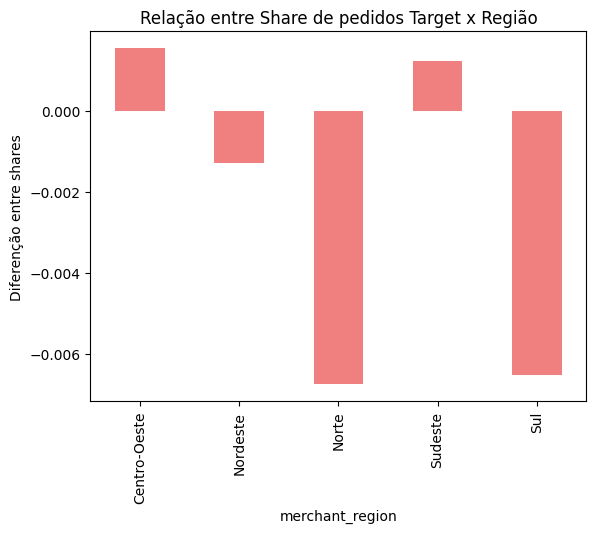

In [44]:
# merchant_region
restaurant_order_agg = restaurant_order.groupby('merchant_region').agg({'target_orders': 'sum',
                                                'target_total_amount': 'sum',
                                                'target_customers': 'count',
                                                'control_orders': 'sum',
                                                'control_total_amount': 'sum',
                                                'control_customers': 'count'})

restaurant_order_agg['share_target_orders'] = restaurant_order_agg['target_orders'] / (restaurant_order_agg['target_orders'] + restaurant_order_agg['control_orders'])
restaurant_order_agg['share_target_orders_relative'] = restaurant_order_agg['share_target_orders'] - share_target
restaurant_order_agg['avg_orders'] = restaurant_order_agg['target_orders'] / restaurant_order_agg['target_customers'] 

display(restaurant_order_agg[['target_orders','control_orders','avg_orders','share_target_orders','share_target_orders_relative']])

restaurant_order_agg['share_target_orders_relative'].plot(kind='bar', color= 'lightcoral')
plt.title("Relação entre Share de pedidos Target x Região")
plt.ylabel("Diferenção entre shares")  
plt.show()

Ao calcular o Share de pedidos relativo estamos subtraindo o Share de pedidos feito por target da média geral de Share de pedidos feito por target. Isso nos permite entender a concentração de usuários targets que participaram do estudo. E nesse contexto Sudeste e Centro-Oeste foram as duas principais regiões, na quais tivemos share de pedidos maiores que a média global.

,target_orders,control_orders,avg_orders,share_target_orders,share_target_orders_relative
average_ticket_tratado,,,,,
0.0,30,20,15.000000,0.600000,0.016563
10.0,69,52,69.000000,0.570248,-0.013189
20.0,5,3,5.000000,0.625000,0.041563
30.0,402444,285076,230.099485,0.585356,0.001919
40.0,424551,303649,287.636179,0.583014,-0.000423
50.0,10,6,5.000000,0.625000,0.041563
60.0,797189,571601,323.797319,0.582404,-0.001033
80.0,457460,326147,328.635057,0.583788,0.000351
100.0,54987,39022,266.927184,0.584912,0.001475


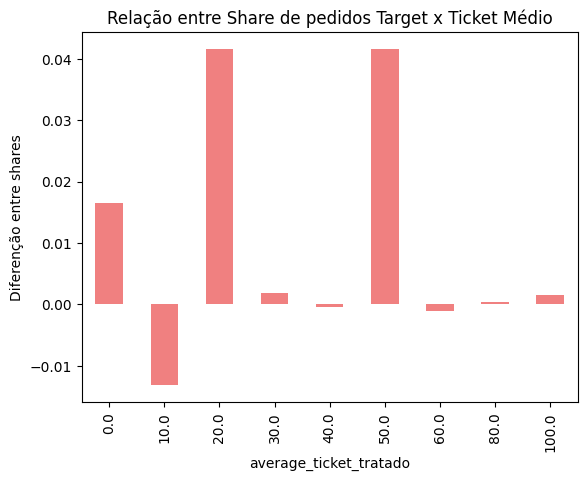

In [45]:
# average_ticket_tratado
restaurant_order_agg = restaurant_order.groupby('average_ticket_tratado').agg({'target_orders': 'sum',
                                                'target_total_amount': 'sum',
                                                'target_customers': 'count',
                                                'control_orders': 'sum',
                                                'control_total_amount': 'sum',
                                                'control_customers': 'count'})

restaurant_order_agg['share_target_orders'] = restaurant_order_agg['target_orders'] / (restaurant_order_agg['target_orders'] + restaurant_order_agg['control_orders'])
restaurant_order_agg['share_target_orders_relative'] = restaurant_order_agg['share_target_orders'] - share_target
restaurant_order_agg['avg_orders'] = restaurant_order_agg['target_orders'] / restaurant_order_agg['target_customers'] 

display(restaurant_order_agg[['target_orders','control_orders','avg_orders','share_target_orders','share_target_orders_relative']])

restaurant_order_agg['share_target_orders_relative'].plot(kind='bar', color= 'lightcoral')
plt.title("Relação entre Share de pedidos Target x Ticket Médio")
plt.ylabel("Diferenção entre shares")  
plt.show()

Não existe variação pois todos os restaurante da base possuem 23 meses desde a ativação.

,target_orders,control_orders,avg_orders,share_target_orders,share_target_orders_relative
city_is_capital,,,,,
Capital,1629049,1161608,325.80980,0.583751,0.000314
Outras Cidades,507696,363968,221.60454,0.582445,-0.000992


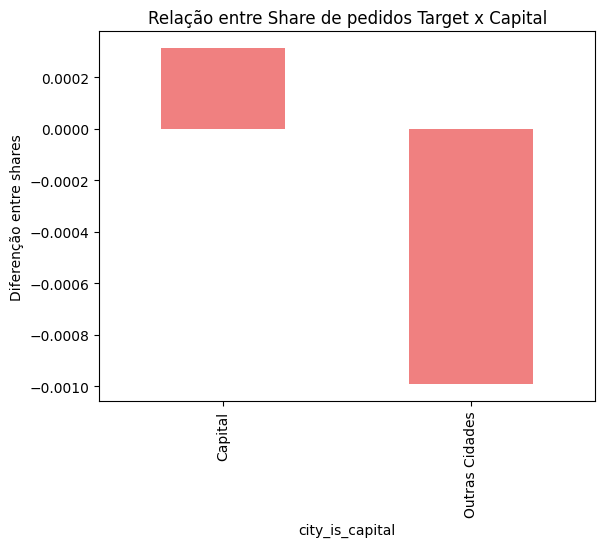

In [46]:
# city_is_capital
restaurant_order_agg = restaurant_order.groupby('city_is_capital').agg({'target_orders': 'sum',
                                                'target_total_amount': 'sum',
                                                'target_customers': 'count',
                                                'control_orders': 'sum',
                                                'control_total_amount': 'sum',
                                                'control_customers': 'count'})

restaurant_order_agg['share_target_orders'] = restaurant_order_agg['target_orders'] / (restaurant_order_agg['target_orders'] + restaurant_order_agg['control_orders'])
restaurant_order_agg['share_target_orders_relative'] = restaurant_order_agg['share_target_orders'] - share_target
restaurant_order_agg['avg_orders'] = restaurant_order_agg['target_orders'] / restaurant_order_agg['target_customers'] 

display(restaurant_order_agg[['target_orders','control_orders','avg_orders','share_target_orders','share_target_orders_relative']])

restaurant_order_agg['share_target_orders_relative'].plot(kind='bar', color= 'lightcoral')
plt.title("Relação entre Share de pedidos Target x Capital")
plt.ylabel("Diferenção entre shares")  
plt.show()

Observamos que existe uma proporção maior de pedidos em Capitais do que em Outras Cidades 

,target_orders,control_orders,avg_orders,share_target_orders,share_target_orders_relative
meses_relativos,,,,,
23,2136745,1525576,293.066109,0.58344,0.0


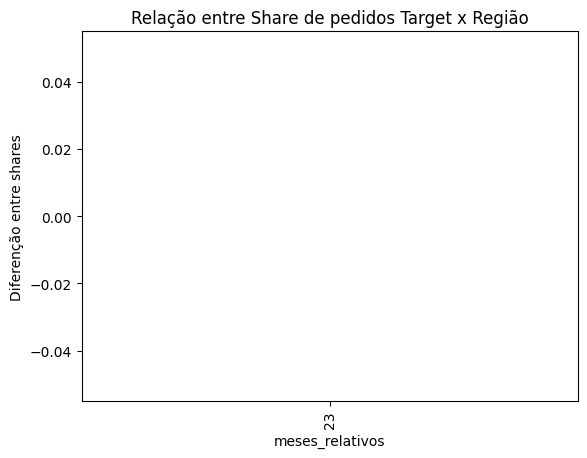

In [47]:
# meses_relativos
restaurant_order_agg = restaurant_order.groupby('meses_relativos').agg({'target_orders': 'sum',
                                                'target_total_amount': 'sum',
                                                'target_customers': 'count',
                                                'control_orders': 'sum',
                                                'control_total_amount': 'sum',
                                                'control_customers': 'count'})

restaurant_order_agg['share_target_orders'] = restaurant_order_agg['target_orders'] / (restaurant_order_agg['target_orders'] + restaurant_order_agg['control_orders'])
restaurant_order_agg['share_target_orders_relative'] = (restaurant_order_agg['share_target_orders']).round(2) - (share_target).round(2)
restaurant_order_agg['avg_orders'] = restaurant_order_agg['target_orders'] / restaurant_order_agg['target_customers'] 

display(restaurant_order_agg[['target_orders','control_orders','avg_orders','share_target_orders','share_target_orders_relative']])

restaurant_order_agg['share_target_orders_relative'].plot(kind='bar', color= 'lightcoral')
plt.title("Relação entre Share de pedidos Target x Região")
plt.ylabel("Diferenção entre shares")  
plt.show()

### 4.2.2 Exploração Consumidores

In [48]:
customer_plataform = order.select('customer_id','origin_platform').distinct().groupBy(
    'customer_id'
).agg(
    when(count('origin_platform') > 1, lit('MIX')).otherwise(first('origin_platform')).alias('origin_platform')
).toPandas()

In [49]:
consumer_seg = consumer_total_amount.merge(customer_plataform, on = 'customer_id', how = 'left')
consumer_seg

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price,origin_platform
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400,ANDROID
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000,IOS
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000,ANDROID
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000,ANDROID
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567,IOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806151,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,pt-br,2018-01-21 14:54:13.123,True,SUZY,44,913950529,target,2,1,94.00,30.0000,47.0000,ANDROID
806152,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,pt-br,2018-01-07 21:55:07.377,True,Gustavo,15,9534999,target,9,4,716.20,6.6232,79.5778,IOS
806153,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,pt-br,2018-01-03 13:34:50.747,True,MARA,45,831631680,target,4,2,192.60,11.4560,48.1500,IOS
806154,fffef917711775d1ba63ec1d8054f9705177edef950699...,pt-br,2018-04-05 10:16:05.922,True,JOAO,34,713368500,control,2,1,47.60,30.0000,23.8000,IOS


Para seguir com as análises de Segmentação irei considerar como principal indicador o média de pedidos, por isso irei retirar os outliers de avg_orders da base.

In [50]:
# Exclude outliers
# Find out quantile, minimun and max
Q1 = consumer_seg['qtde_orders'].quantile(0.25)
Q2 = consumer_seg['qtde_orders'].quantile(0.50)
Q3 = consumer_seg['qtde_orders'].quantile(0.75)
IQR = Q3 - Q1
Min = Q1 - (1.5 * IQR)
Max = Q3 + (1.5 * IQR)

# Filter outliers
consumer_seg_witout_outliers = consumer_seg[(consumer_seg['qtde_orders'] > Min) & (consumer_seg['qtde_orders'] < Max)].copy()
consumer_seg_witout_outliers

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price,origin_platform
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400,ANDROID
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000,IOS
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000,ANDROID
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000,ANDROID
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567,IOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806151,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,pt-br,2018-01-21 14:54:13.123,True,SUZY,44,913950529,target,2,1,94.00,30.0000,47.0000,ANDROID
806152,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,pt-br,2018-01-07 21:55:07.377,True,Gustavo,15,9534999,target,9,4,716.20,6.6232,79.5778,IOS
806153,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,pt-br,2018-01-03 13:34:50.747,True,MARA,45,831631680,target,4,2,192.60,11.4560,48.1500,IOS
806154,fffef917711775d1ba63ec1d8054f9705177edef950699...,pt-br,2018-04-05 10:16:05.922,True,JOAO,34,713368500,control,2,1,47.60,30.0000,23.8000,IOS


Para facilitar os agrupamentos também criei dois novos campos com o intuito de trazer apenas dados de target ou control. Também criei um campo Região, que leva em consideração o DDD do consumidor. Como premissa entnedo que o DDD corresponde a cidade que o cosnumidor mora.

In [51]:
consumer_seg_witout_outliers['target_orders_qtde_orders'] = np.where(consumer_seg_witout_outliers['is_target'] == 'target', 
                                                                    consumer_seg_witout_outliers['qtde_orders'], None)
consumer_seg_witout_outliers['control_orders_qtde_orders'] = np.where(consumer_seg_witout_outliers['is_target'] == 'control', 
                                                                      consumer_seg_witout_outliers['qtde_orders'], None)
consumer_seg_witout_outliers['target_customer'] = np.where(consumer_seg_witout_outliers['is_target'] == 'target', 
                                                           consumer_seg_witout_outliers['customer_id'], None)
consumer_seg_witout_outliers['control_customer'] = np.where(consumer_seg_witout_outliers['is_target'] == 'control', 
                                                            consumer_seg_witout_outliers['customer_id'], None)

# Criando a coluna de região
regioes = {
    'Norte': [68, 96, 92, 97, 91, 93, 94, 98, 99, 69, 95],
    'Nordeste': [82, 71, 73, 74, 75, 77, 85, 88, 83, 87, 86, 89, 84, 79],
    'Centro-Oeste': [61, 62, 64, 65, 66, 67, 63],
    'Sudeste': [27, 28, 31, 32, 33, 34, 35, 37, 38, 21, 22, 24, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    'Sul': [41, 42, 43, 44, 45, 46, 51, 53, 54, 55, 47, 48, 49]
}
consumer_seg_witout_outliers['merchant_region'] = consumer_seg_witout_outliers['customer_phone_area'].map({ddd: regiao for regiao, ddds in regioes.items() for ddd in ddds}).fillna('Informação Inconsistente')
consumer_seg_witout_outliers

consumer_seg_witout_outliers

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,qtde_orders,qtde_merchant_id,order_total_amount,avg_time_between_orders,avg_order_price,origin_platform,target_orders_qtde_orders,control_orders_qtde_orders,target_customer,control_customer,merchant_region
0,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,pt-br,2018-01-04 13:16:01.061,True,SILVIA,87,781841665,target,5,3,79.70,11.3178,15.9400,ANDROID,5,None,00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab...,None,Nordeste
1,00029b26fb2121119b6d07a275088befd3535f26f38787...,pt-br,2018-01-03 21:03:27.420,True,SIMONE,43,60750759,target,1,1,54.60,NaN,54.6000,IOS,1,None,00029b26fb2121119b6d07a275088befd3535f26f38787...,None,Sul
2,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,pt-br,2018-04-06 01:24:07.809,True,FRANCISCO,91,97850192,control,2,1,87.80,30.0000,43.9000,ANDROID,None,2,None,0002cc7394d677fdf520b27cd0221126660161ecf50d49...,Norte
3,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,pt-br,2018-04-05 12:23:33.647,True,DANIEL,50,931927401,control,2,2,69.00,23.0203,34.5000,ANDROID,None,2,None,0003fc1a7fe21c5f4140f811a873c5f28c21ec971b79c2...,Informação Inconsistente
4,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,pt-br,2018-04-05 17:20:45.219,True,NINA,98,4761556,target,3,3,175.07,6.4860,58.3567,IOS,3,None,000405bb6de6550fec397a30cb9a5b4876726f68f372d5...,None,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806151,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,pt-br,2018-01-21 14:54:13.123,True,SUZY,44,913950529,target,2,1,94.00,30.0000,47.0000,ANDROID,2,None,fffceb5e60736f7b3cec25c1bed385d9b53e6e20cc9ab8...,None,Sul
806152,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,pt-br,2018-01-07 21:55:07.377,True,Gustavo,15,9534999,target,9,4,716.20,6.6232,79.5778,IOS,9,None,fffd246e214458105c2ca4b6910dd57d2fc44a4a029540...,None,Sudeste
806153,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,pt-br,2018-01-03 13:34:50.747,True,MARA,45,831631680,target,4,2,192.60,11.4560,48.1500,IOS,4,None,fffebe8f36625fbc708361eeaa301fee40b849e2bf4666...,None,Sul
806154,fffef917711775d1ba63ec1d8054f9705177edef950699...,pt-br,2018-04-05 10:16:05.922,True,JOAO,34,713368500,control,2,1,47.60,30.0000,23.8000,IOS,None,2,None,fffef917711775d1ba63ec1d8054f9705177edef950699...,Sudeste



----- Performing a t-test for ANDROID -----
Tamanho de target: 165215, Tamanho de control: 137707
t-statistic: 39.5942
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for IOS -----
Tamanho de target: 157011, Tamanho de control: 129474
t-statistic: 38.7347
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for DESKTOP -----
Tamanho de target: 49185, Tamanho de control: 42871
t-statistic: 22.7529
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for WINDOWS_PHONE -----
Tamanho de target: 3402, Tamanho de control: 2868
t-statistic: 5.3706
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for MIX -----
Tamanho de target: 16871, Tamanho de control: 11225
t-statistic: 1.0524
p-value: 0.2926
Not statistically significant (fail to reject H₀).


/opt/anaconda3/envs/case_ifood_25/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)



----- Performing a t-test for None -----
Tamanho de target: 0, Tamanho de control: 0
t-statistic: nan
p-value: nan
Not statistically significant (fail to reject H₀).


,target_orders_qtde_orders,control_orders_qtde_orders,target_customer,control_customer,qtde_orders,target_avg_orders,target_avg_orders_relative
origin_platform,,,,,,,
ANDROID,490051,369010,165215,137707,859061,2.966141,-0.143859
DESKTOP,133503,104506,49185,42871,238009,2.714303,-0.395697
IOS,497364,370872,157011,129474,868236,3.167702,0.057702
MIX,87413,57864,16871,11225,145277,5.181258,2.071258
WINDOWS_PHONE,9179,7022,3402,2868,16201,2.698119,-0.411881


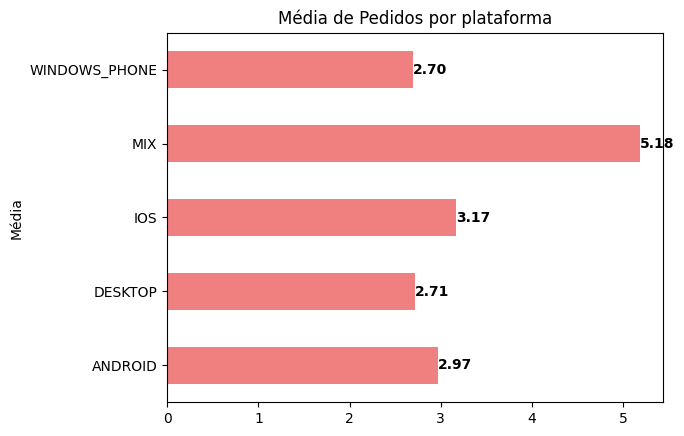

In [52]:
# origin_platform
variavel = 'origin_platform'
# Relevancia Estatitica
for plataform in consumer_seg_witout_outliers[variavel].unique().tolist():
    target = consumer_seg_witout_outliers[
        (consumer_seg_witout_outliers['is_target'] == 'target') & 
        (consumer_seg_witout_outliers[variavel] == plataform) & 
        (consumer_seg_witout_outliers['target_orders_qtde_orders'].notna())
    ]['target_orders_qtde_orders'].astype(float).reset_index(drop=True)

    control = consumer_seg_witout_outliers[
        (consumer_seg_witout_outliers['is_target'] == 'control') & 
        (consumer_seg_witout_outliers[variavel] == plataform) & 
        (consumer_seg_witout_outliers['control_orders_qtde_orders'].notna())
    ]['control_orders_qtde_orders'].astype(float).reset_index(drop=True)

    # Teste t para amostras independentes
    t_stat, p_value = stats.ttest_ind(target, control, equal_var=False)

    print(f'\n----- Performing a t-test for {plataform} -----')
    print(f'Tamanho de target: {len(target)}, Tamanho de control: {len(control)}')
    print(f't-statistic: {t_stat:.4f}')
    print(f'p-value: {p_value:.4f}')

    if p_value < 0.05:
        print('Statistically significant result (reject H₀).')
    else:
        print('Not statistically significant (fail to reject H₀).')

# Tabela e Gráfico
consumer_seg_agg = consumer_seg_witout_outliers.groupby(variavel).agg({'target_orders_qtde_orders': 'sum',
                                                                                'control_orders_qtde_orders': 'sum',
                                                                                'target_customer': 'count',
                                                                                'control_customer': 'count'
                                                                               })

consumer_seg_agg['qtde_orders'] = (consumer_seg_agg['target_orders_qtde_orders'] + consumer_seg_agg['control_orders_qtde_orders']).astype(int)
consumer_seg_agg['target_avg_orders'] = consumer_seg_agg['target_orders_qtde_orders'] / consumer_seg_agg['target_customer']
consumer_seg_agg['target_avg_orders_relative'] = consumer_seg_agg['target_avg_orders'] - 3.11 # Média de pedidos do grupo controle

display(consumer_seg_agg)

consumer_seg_agg['target_avg_orders'].plot(kind='barh', color= 'lightcoral')
plt.title("Média de Pedidos por plataforma")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.2f", fontsize=10, fontweight="bold", color="black")
plt.ylabel("Média")  
plt.show()


----- Performing a t-test for Nordeste -----
Tamanho de target: 54739, Tamanho de control: 45703
t-statistic: 23.8756
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for Sul -----
Tamanho de target: 50788, Tamanho de control: 42198
t-statistic: 21.5849
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for Norte -----
Tamanho de target: 43230, Tamanho de control: 35692
t-statistic: 21.6316
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for Informação Inconsistente -----
Tamanho de target: 133367, Tamanho de control: 110129
t-statistic: 34.3868
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for Centro-Oeste -----
Tamanho de target: 27300, Tamanho de control: 22758
t-statistic: 16.0275
p-value: 0.0000
Statistically significant result (reject H₀).

----- Performing a t-test for Sudeste -----
Tamanho de target: 82260, Tamanho de

,target_orders_qtde_orders,control_orders_qtde_orders,target_customer,control_customer,target_avg_orders,target_avg_orders_relative
merchant_region,,,,,,
Centro-Oeste,84765,63893,27300,22758,3.104945,-0.005055
Informação Inconsistente,413414,309606,133367,110129,3.099822,-0.010178
Nordeste,170328,127964,54739,45703,3.111639,0.001639
Norte,134840,99966,43230,35692,3.11913,0.00913
Sudeste,256984,189610,82260,67666,3.124046,0.014046
Sul,157179,118237,50788,42198,3.094806,-0.015194


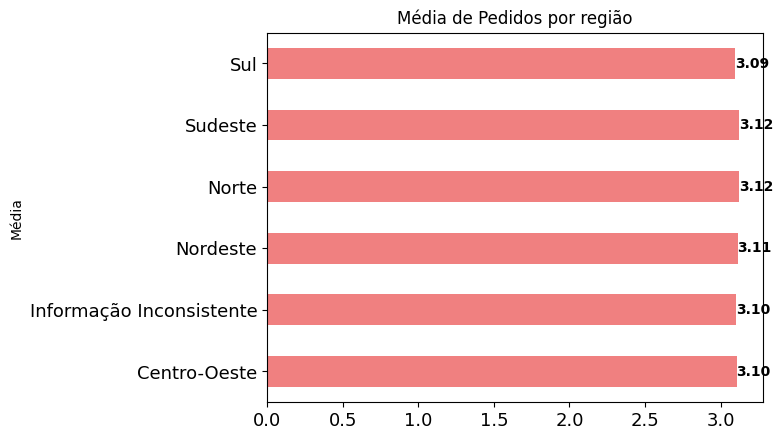

In [53]:
# merchant_region
variavel = 'merchant_region'
# Relevancia Estatitica
for plataform in consumer_seg_witout_outliers[variavel].unique().tolist():
    target = consumer_seg_witout_outliers[
        (consumer_seg_witout_outliers['is_target'] == 'target') & 
        (consumer_seg_witout_outliers[variavel] == plataform) & 
        (consumer_seg_witout_outliers['target_orders_qtde_orders'].notna())
    ]['target_orders_qtde_orders'].astype(float).reset_index(drop=True)

    control = consumer_seg_witout_outliers[
        (consumer_seg_witout_outliers['is_target'] == 'control') & 
        (consumer_seg_witout_outliers[variavel] == plataform) & 
        (consumer_seg_witout_outliers['control_orders_qtde_orders'].notna())
    ]['control_orders_qtde_orders'].astype(float).reset_index(drop=True)

    # Teste t para amostras independentes
    t_stat, p_value = stats.ttest_ind(target, control, equal_var=False)

    print(f'\n----- Performing a t-test for {plataform} -----')
    print(f'Tamanho de target: {len(target)}, Tamanho de control: {len(control)}')
    print(f't-statistic: {t_stat:.4f}')
    print(f'p-value: {p_value:.4f}')

    if p_value < 0.05:
        print('Statistically significant result (reject H₀).')
    else:
        print('Not statistically significant (fail to reject H₀).')

# Tabela e Gráfico
consumer_seg_agg = consumer_seg_witout_outliers.groupby(variavel).agg({'target_orders_qtde_orders': 'sum',
                                                                                'control_orders_qtde_orders': 'sum',
                                                                                'target_customer': 'count',
                                                                                'control_customer': 'count'
                                                                               })

consumer_seg_agg['target_avg_orders'] = consumer_seg_agg['target_orders_qtde_orders'] / consumer_seg_agg['target_customer']
consumer_seg_agg['target_avg_orders_relative'] = consumer_seg_agg['target_avg_orders'] - 3.11 # Média de pedidos do grupo controle

display(consumer_seg_agg)

consumer_seg_agg['target_avg_orders'].plot(kind='barh', color= 'lightcoral', fontsize=13)
plt.title("Média de Pedidos por região")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.2f", fontsize=10, fontweight="bold", color="black")
plt.ylabel("Média")  
plt.show()

### Conclusões

**a) Definir as segmentações que fazem sentido especificamente para o teste A/B que está analisando.**
Para avaliar o impacto da campanha de cupons de forma segmentada, foram definidas as seguintes segmentações:
- Visão Consumidor: Plataforma de origem do pedido e Região do DDD
- Visão Restaurantes: Região e Ticket Médio

**b) Estabelecer quais serão os critérios utilizados para cada semento sugerido no item a). Utilize os critérios/ferramentas que achar necessários, mas lembre-se de explicar o racional utilizado na criação.**

- **Plataforma de Origem do Pedido:** A plataforma utilizada pode impactar o comportamento do consumidor e a adesão à promoção. IOS apresentou maior volume de pedidos na análise geral, enquanto o grupo Mix teve a maior média de pedidos, mas não teve significância estatística. Método: Análise estatística via teste t para verificar diferenças significativas entre grupos.
- **Região do DDD:** A localização geográfica influencia hábitos de consumo e adesão às promoções. Sudeste e Norte se destacaram na média de pedidos. Método: Análise estatística via teste t para verificar diferenças significativas entre grupos.
- **Região do Restaurante:** Restaurantes de determinadas regiões podem ter maior participação em pedidos incentivados pelos cupons. Método: Avaliação de distribuição geográfica dos restaurantes.
- **Ticket Médio:** Restaurantes com faixas de ticket médio específicas podem ser mais responsivos a promoções. A faixa de R$30 a R$50 se destacou. Método: Avaliação de distribuição entre ticket médio dos restaurantes.

c) Analisar os resultados do teste A/B com base nos segmentos definidos nos itens a) e b).
- **Plataforma de Origem do Pedido:**  O IOS teve desempenho ligeiramente acima da média (3.16 pedidos), mas sem diferença significativa em relação às demais plataformas.
- **Região do DDD:** Sudeste (3.12 pedidos) e Norte (3.11 pedidos) apresentaram a maior média, mas sem diferenças estatísticas relevantes entre regiões.
- **Região do Restaurante:** Sudeste e Centro-Oeste concentraram a maior participação de pedidos, mas a variação foi pequena.
- **Ticket Médio:** Restaurantes com ticket entre R$30 e R$50 tiveram maior impacto na adesão à campanha.

## 4.3 Parte 3
3. Com base na análise que realizou nas questões 1 e 2, sugira os próximos passos que o iFood deve tomar. Lembre-se que você precisa defender suas sugestões para as lideranças de Negócio, por isso não esqueça de incluir uma previsão de impacto (financeiro ou não) caso o iFood siga com a sua recomendação. Fique à vontade para sugerir melhorias no processo/teste e para propor diferentes estratégias de acordo com cada segmento de usuário.

Conclusão
Pensando num planejamento de teste foi criado um simulador. E por imaginar que esse simulador irá circular por pessoas de Negócios, preferi cria-lo em um Excel, por ter uma interface mais amigável.